# 10. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is an act of making your machine learning model(s) available for someone/something else.



<img src="Deployment -1.png">

<img src="Deployment -2.png">

<img src="Deployment -3.png">

<img src="Deployment -4.png">

## 0. Get Setup

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torchinfo import summary
import matplotlib.pyplot as plt
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

The dataset we're going to use for deployaing a FoodVision Mini Model is...

Pizza, steak and sushi 20% dataset.

We can get data with code from - https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [2]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [3]:
# Setup training and test paths

train_dir = data_20_percent_path/"train"
test_dir = data_20_percent_path/"test"

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast.

* Performs well: 95%+ accuracy
* Fast: as close to realtime (or faster) as possible (30FPS+ or 30ms latency)
    * Latency = time for prediction to take place
    
To try and achieve these goals, we are going to build 2 model experiments:

1. EffNetB2 feature extractor
2. ViT feature extractor

## 3. Creating and EffNetB2 feature extractor

Feature extractor = a term for transfer learning model that has it's base layers frozen and head layers customized for certain problem.

EffNetB2 pretrined model in PyTorch = https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html

In [4]:
# 1. Setup pretrained weights
effnet_b2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 Transforms
effnetb2_transforms = effnet_b2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnet_b2_weights)

# 4. Freezing the base layers
for param in effnetb2.parameters():
    param.requires_grad = False

In [5]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [6]:
# Set seeds for reproducability
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
             out_features=3,
             bias=True)
)

effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [7]:
def create_effnetb2_model(num_classes: int=3,
                         seed: int=42):
    # 1, 2, 3 Create Effnetb2 weights, transform and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    # 4. Freeze all layers in the base model
    for param in model.parameters():
        param.requires_grad = False
        
    # 5. Change the classifier head with seed42
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,
                 out_features=num_classes)
    )
    
    return model, transforms

In [8]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                     seed=42)

In [9]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

### 3.2 Creating Dataloaders for EffNetB2

In [11]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32,
    num_workers=2
)

train_dataloader_effnetb2, len(test_dataloader_effnetb2), class_names

(<torch.utils.data.dataloader.DataLoader at 0x299c9d67e20>,
 5,
 ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [12]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer 
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                           lr=1e-3)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2.to(device),
                               train_dataloader=train_dataloader_effnetb2,
                               test_dataloader=test_dataloader_effnetb2,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               epochs=10,
                               device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9855 | train_acc: 0.5625 | test_loss: 0.7408 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7174 | train_acc: 0.8438 | test_loss: 0.5869 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5876 | train_acc: 0.8917 | test_loss: 0.4909 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4474 | train_acc: 0.9083 | test_loss: 0.4355 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4290 | train_acc: 0.9104 | test_loss: 0.3916 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4380 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4245 | train_acc: 0.8771 | test_loss: 0.3268 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3897 | train_acc: 0.8958 | test_loss: 0.3457 | test_acc: 0.9290
Epoch: 9 | train_loss: 0.3749 | train_acc: 0.8812 | test_loss: 0.3130 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3757 | train_acc: 0.8604 | test_loss: 0.2813 | test_acc: 0.9688


### 3.4 Inspecting EffNetB2 Loss Curves

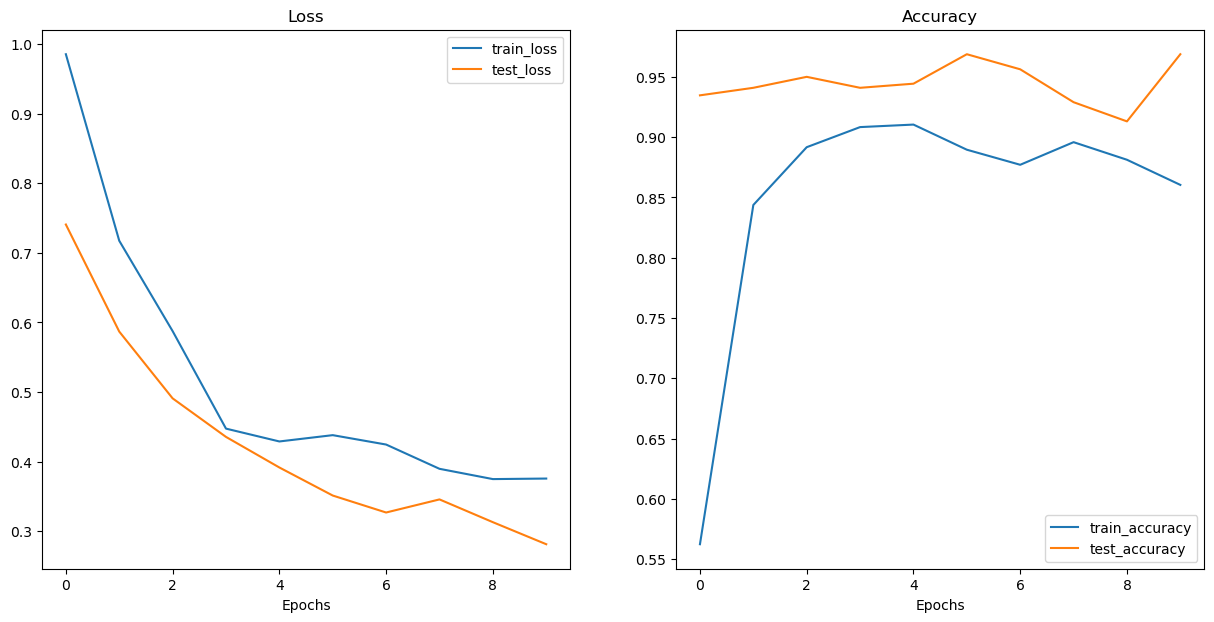

In [13]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [14]:
from going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="10_pretrained_effnetb2_20_percent.pth")

[INFO] Saving model to: models\10_pretrained_effnetb2_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [15]:
from pathlib import Path

pretrained_effnetb2_size = Path("models/10_pretrained_effnetb2_20_percent.pth").stat().st_size // (1024*1024)

print(f"Size of effnetb2 model: {pretrained_effnetb2_size} MB")

Size of effnetb2 model: 29 MB


### 3.7 Collect EffNetB2 feature extractor stats

In [16]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [17]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                 "model_size (MB)": pretrained_effnetb2_size}

effnetb2_stats

{'test_loss': 0.28127655386924744,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4. Creating a ViT feature extractor

We're up to our second modeling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor

In [18]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [19]:
def create_vit_model(num_classes:int =3,
                    seed:int=42):
    # Create ViT_B_16 pretrained weights, transformer and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)
    
    # Freeze all the base layers
    for param in model.parameters():
        param.requires_grad = False
        
    # Change the classifier head 
    torch.manual_seed(seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768,
                 out_features=num_classes)
    )
    
    return model, transforms

In [20]:
vit, vit_transforms = create_vit_model(num_classes=3,
                                      seed=42)

vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 4.1 Create DataLoaders for ViT feature extractor

In [21]:
# Setup ViT Dataloaders 
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Feature extractor

In [22]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                            lr=1e-3)

# Training model
torch.manual_seed(42)
vit_results = engine.train(model=vit.to(device),
                            train_dataloader=train_dataloader_vit,
                            test_dataloader=test_dataloader_vit,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=10,
                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


### 4.3 Plot loss curve of ViT Feature extractor

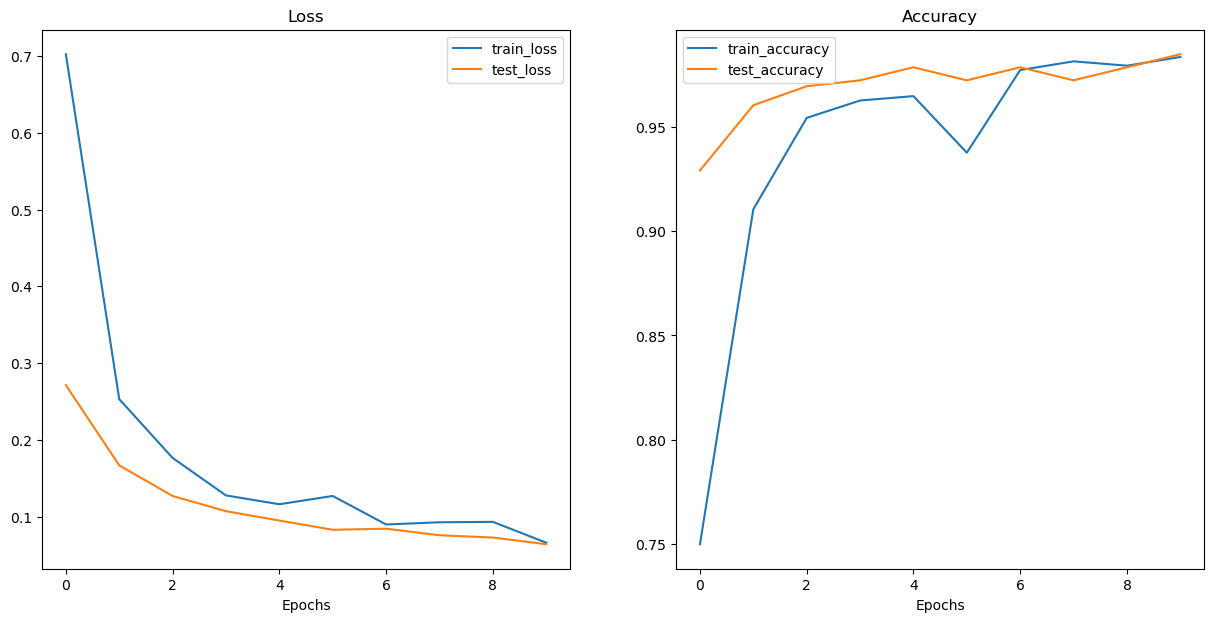

In [23]:
plot_loss_curves(vit_results)

### 4.4 Saving ViT Feature Extractor

In [24]:
from going_modular import utils

utils.save_model(model=vit,
                target_dir="models",
                model_name="10_pretrained_vit_20_percent.pth")

[INFO] Saving model to: models\10_pretrained_vit_20_percent.pth


### 4.5 Check the size of model

In [25]:
pretrained_vit_model_size = Path("models/10_pretrained_vit_20_percent.pth").stat().st_size // (1024*1024)

print(f"Size of ViT Model: {pretrained_vit_model_size} MB")

Size of ViT Model: 327 MB


### 4.6 Collecting ViT Feature Extractor Stats

In [26]:
# Count number of parametes in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [27]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats


{'test_loss': 0.06418211059644818,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with our trained models and timing

Our goal: 
1. Performs well (95%+ test accuracy)
2. Fast!  (30+FPS)

To test criteria two:
1. Loop through test images
2. To time how long each model takes to make a prediction on the image

Let's work towards making a prediction called `pred_and_store()` to do so.

In [28]:
from pathlib import Path

# Get alll test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:3]

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg')]

### 5.1 Creating a function to make prediction across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths and trained PyTorch model, a series of transforms, a list of target class names and target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths.
4. Create an empty dictionary for each sample. (Prediction stats)
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [29]:
import pathlib 
import torch

from typing import List, Dict, Tuple
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

# 1. Create a function 
def pred_and_store(paths: List[pathlib.Path],
                  model: torch.nn.Module,
                  transform: torchvision.transforms,
                  class_names: List[str],
                  device:str= "cuda") -> List[Dict]:
    
    # 2. Create an empty list
    pred_list = []
    
    # 3. Loop through the target input paths
    for path in tqdm(paths):
        
        # 4. Create an empty dictionary for each sample
        pred_dict = {}
        
        # 5. Get the sample path and ground truth class from filepath.
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open the image using `PIL.Image.open(Path)
        img = Image.open(path)
        
        # 8. Transform the image to be usable with given model
        transformed_image = transform(img).unsqueeze(0).to(device)
        
        # Prepare the model for infererence 
        model = model.to(device)
        model.eval()
        
        # 10. Turn on inferernce mode
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]  # Python variables are on cpu
            
            # 11. Add the pred prob and pred class to empty dict from step 4
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the prediction timer
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)
            
        # 13. See if the predicted class matches the ground truth class
        pred_dict["correct"] = class_name == pred_class
        
        # 14. Append the updated prediction dictionary to the empty list of predictions
        pred_list.append(pred_dict)
        
    # 15. REturn the list of pred dictionaries
    return pred_list

### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()`

2 things to note:
1. Device -  we're going to hardcode our predictions to happen on CPU
2. Transforms - we want to make sure each of the models are prediction on images that have been prepared with the appropraite tansforms.

In [30]:
# Make predictions across test dataset
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                         model=effnetb2,
                                         transform=effnetb2_transforms,
                                         class_names=class_names,
                                         device="cpu")



  0%|          | 0/150 [00:00<?, ?it/s]

In [31]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9941,
  'pred_class': 'pizza',
  'time_for_pred': 0.1187,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4901,
  'pred_class': 'pizza',
  'time_for_pred': 0.0744,
  'correct': True}]

In [32]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9941,pizza,0.1187,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4901,pizza,0.0744,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9922,pizza,0.0739,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.6917,pizza,0.0745,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7661,pizza,0.0740,True


In [33]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

In [34]:
# Find the average time per predictions
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.0767


> **Note:** Prediction times vary depending on the hardware

In [35]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28127655386924744,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0767}

### 5.3 Making and Timing predictions with ViT

In [36]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                    model=vit,
                                    transform=vit_transforms,
                                    class_names=class_names,
                                    device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9986,pizza,0.1471,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9957,pizza,0.0812,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.0819,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9869,pizza,0.0793,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9710,pizza,0.0809,True


In [38]:
# See how many correct
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [39]:
# Calculate average time per prediction for ViT Model

vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.0819


In [40]:
# Add average time per prediciton to ViT Stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418211059644818,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.0819}

### 6. Comparing model results, prediction times and size

In [41]:
# Turn stats dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"]*100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281277,96.88,7705221,29,0.0767,EffNetB2
1,0.064182,98.47,85800963,327,0.0819,ViT


Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - EffNetB2 (If a model has more parameteres, it generally takes longer to compute)

    - *Sometimes models with higher paramteres can perform fast
    
* `model_size (MB)` -  EffNetB2 (generally smaller is better)
* `time_per_pred_cpu` - (lower is better, will be highly dependent on hardware) -  EffNetB2

Both models fail to acheive our goal of 30+FPS ... however we could always try and see EffNetB2.

In [42]:
# Compare ViT to EffNetB2 accross different characteristics

pd.DataFrame(df.set_index("model").loc['ViT'] / df.set_index('model').loc["EffNetB2"] ,
            columns=["ViT to EffNetb2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetb2 ratios,0.228182,1.016412,11.135432,11.275862,1.067797


### 6.1 Visualizing the speed vs performance tradeoff

So we've compared our both models, now lets visualize the comparison with a speed vs performance plot.

We do so with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels
3. Annote the samples on the scatter plot.
4. Create a legend based on the model sizes (`model_size (MB)`)

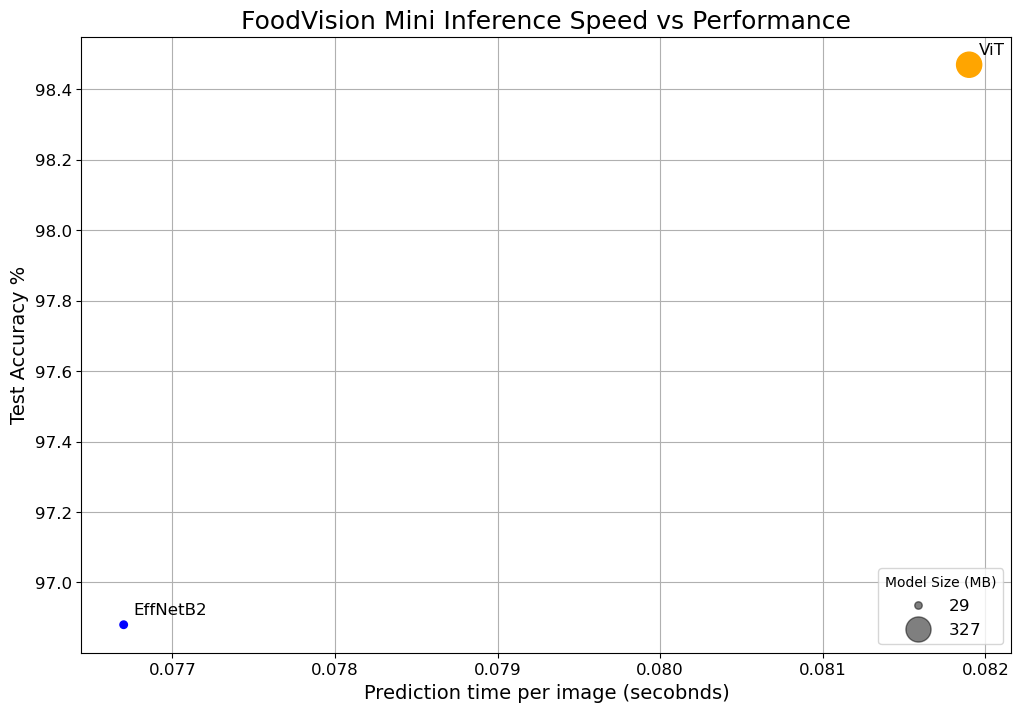

In [43]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                    x="time_per_pred_cpu",
                    y="test_acc",
                    c=["blue", "orange"],
                    s="model_size (MB)")

# 2. Add titles and labels
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (secobnds)", fontsize=14)
ax.set_ylabel("Test Accuracy %", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annothe the samples
for index, row in df.iterrows():
    ax.annotate(text=row["model"],
               xy=(row["time_per_pred_cpu"]+0.00006, row["test_acc"]+0.03),
               size=12)
    
# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, labels,
                              loc="lower right",
                             title="Model Size (MB)",
                             fontsize=12)

# SAve the figure
plt.savefig("10-foodvision-mini-inference-speed-vs-performance.png")

## 7. Bringing FoodVision Mini to life by creating Gradio Demo

We've chosen to deploy EffNetB2 as it fulfills the criteria as close as possible.

What is Gradio?

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

### 7.1 Gradio overview

Gradio helps you create machine learning demo.

Why create a demo?

So other people can test out our model.

Deployment is as important as training.

The overall premise of Gradio is to map inputs -> function/model -> output

### 7.2 Creating a function to map our inputs and outputs

In [44]:
# Put our model on the CPU
effnetb2 = effnetb2.to('cpu')

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food -> ML Model -> output (food class label, time)
```

In [45]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = timer()
        
    # Transform the input image for use with EffNetB2
    transformed_image = effnetb2_transforms(img).unsqueeze(0)  # Adding batch_dim

    # Put model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        pred_prob = torch.softmax(effnetb2(transformed_image), dim=1)
    
    # Create a prediction label and prediction probability dict
    pred_labels_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
    
    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)
    
    return pred_labels_and_probs, pred_time

In [46]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test data path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\steak\399377.jpg
{'pizza': 0.1396377682685852, 'steak': 0.6593673229217529, 'sushi': 0.20099490880966187}
0.076


### 7.3 Creating a list of example images

The examples of Gradio can be created with `examples` parameter.

In [47]:
# Create list of example inputs to our Gradio demo

example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\steak\\86782.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\1683426.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\3479599.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> transform -> predict with EffNetb2 -> output: pred, pred prob, time
```

In [48]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🥩🍕🍥"
description = "An EfficientNetB2 feature extractor CV model to classify food"
article = "Created at 10. PyTorch Model Deployment"

# Create the Gradio Demo
demo = gr.Interface(fn=predict,  #maps input to output
                   inputs=gr.Image(type="pil"),
                   outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                           gr.Number(label="Prediction Time (s)")],
                   examples=example_list,
                   title=title,
                   description=description,
                   article=article)

# Launch the demo!
# demo.launch(debug=False,  #print errors locally?
#            share=True)

## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demos from local machine was fantastic but can't be shared to others.

To fix this, we are going to preapare our app files so we can host them on Huggingface Spaces

### 8.1 What is Hugging Face Spaces?

> Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization’s profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.


If GitHub is a place to show your coding ability. HuggingFace spaces is a place to show your Machine learing ability through sharing ML demos that you have built.

### 8.2 Deployed Gradio App Structure

Let's start to put all of our app files into a single directory:

```
Colab -> folder with all Gradio Files -> upload app files to HuggingFace -> deploy
```

By the end our file structure will look like this 

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
   ```
   
Why use this structure?

Because it's one of the simplest we could start with.

### 8.3 Creating a `demos` folder to store our FoodVision mini app files

In [49]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
    
else:
    foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
    


### 8.4 Creating a folder of example imafges to use with out FoodVision Mini demo

What we want:
* 3 images in an `example`/directory
* Images should be from the test set

In [50]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] copying {example} to {destination}")
    shutil.copy2(src=example,
                dst=destination)

[INFO] copying data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg to demos\foodvision_mini\examples\592799.jpg
[INFO] copying data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg to demos\foodvision_mini\examples\3622237.jpg
[INFO] copying data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg to demos\foodvision_mini\examples\2582289.jpg


Let's now verify that we can get a list of list from our `examples` / directory

In [51]:
import os

# Get examples filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

### 8.5 Moving our trained EffNetB2 Model to our FoodVision mini demo directory

In [52]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/10_pretrained_effnetb2_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split('/')[1]

# Move the model file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
               dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")
    
    # If the model already been moved, check if it exist
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps already been moved")
    print(f"[INFO] Model exist at {effnetb2_foodvision_mini_model_destination} : {effnetb2_foodvision_mini_model_destination.exist()}")

[INFO] Attempting to move models/10_pretrained_effnetb2_20_percent.pth to demos\foodvision_mini\10_pretrained_effnetb2_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning off EffNetB2 model into a python script

We have saved `.pth` model `state_dict` and want to load it into a model instance

In [53]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes: int=3,
                         seed: int=42):
    # 1, 2, 3 Create Effnetb2 weights, transform and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    # 4. Freeze all layers in the base model
    for param in model.parameters():
        param.requires_grad = False
        
    # 5. Change the classifier head with seed42
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,
                 out_features=num_classes)
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app into a Python Script `app.py`

The `app.py` will have 4 major parts:
1. Import and class names setup
2. Model and transforms preparation
3. Callable function for gradio, which in our case is `predict()`
4. Gradio App

In [54]:
%%writefile demos/foodvision_mini/app.py

### 1. Import and class names setup   ###
import torch
import torchvision
import gradio as gr
import os

from torch import nn
from model import create_effnetb2_model
from typing import Tuple, Dict
from timeit import default_timer as timer

# Setup class names
class_names = ['pizza', 'steak', 'sushi']


### 2. Model and transforms preparation  ###
effnetb2, effnetb2_transforms = create_effnetb2_model()

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f="10_pretrained_effnetb2_20_percent.pth",
        map_location=torch.device('cpu')           # ensure it loads in cpu
    )
)


### 3. Predict function  ###
def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = timer()
        
    # Transform the input image for use with EffNetB2
    transformed_image = effnetb2_transforms(img).unsqueeze(0)  # Adding batch_dim

    # Put model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        pred_prob = torch.softmax(effnetb2(transformed_image), dim=1)
    
    # Create a prediction label and prediction probability dict
    pred_labels_and_probs = {class_names[i]: float(pred_prob[0][i]) for i in range(len(class_names))}
    
    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)
    
    return pred_labels_and_probs, pred_time



### 4. Gradio App

# Create title, description and article
title = "FoodVision Mini 🥩🍕🍥"
description = "An EfficientNetB2 feature extractor CV model to classify food"
article = "Created at 10. PyTorch Model Deployment"

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio Demo
demo = gr.Interface(fn=predict,  #maps input to output
                   inputs=gr.Image(type="pil"),
                   outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                           gr.Number(label="Prediction Time (s)")],
                   examples=example_list,
                   title=title,
                   description=description,
                   article=article)

demo.launch(debug=False,  #print errors locally?
           share=True)

Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for Gradio = `requirements.txt`

The requirements file will tell our Hugging Face Space what software dependenvies our app requires.

* `torch`
* `torchvison`
* `gradio`

In [55]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.0.0
torchvision==0.15.0
gradio==3.23.0

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app to Hugging Face Spaces

### 9.1 Downloading our FoodVision mini app files

We want to download our `foodvision_mini` dmeo appso we can upload it to hugging face.

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

* Uploading via the Hugging Face Web interface (easiest).

* Uploading via the command line or terminal.
    * Bonus: You can also use the huggingface_hub library to interact with Hugging Face, this would be a good extension to the above two options.

In [56]:
# USING FIRST METHOD BY CREATING REPO ON HUGGING FACE AND UPLOADING DIRECTLY

### 9.2 Running Gradio demo app locally

https://www.learnpytorch.io/09_pytorch_model_deployment/#92-running-our-foodvision-mini-demo-locally

### 9.3 Uploading our FoodVision Mini Gradio Demo to Hugging Space

We can also share our app yby embeddng it - https://gradio.app/sharing-your-app/#embedding-hosted-spaces

In [60]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
# IFrame(src="https://hf.space/embed/himgos/foodvision_mini/+", width=900, height=750)

## 10. Creating FoodVision Big!!!

FoodVision Mini works well with 3 classes.

So all of experimenting is paying off...

Let's step things up a notch and make FoodVision Mini to FoodVision 101.

### 10.1 Create a model for FoodVision Big + transforms

In [61]:
# Create Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101,
                                                             seed=42)

In [63]:
sum(torch.numel(param) for param in effnetb2_food101.parameters())

7843303

In [64]:
effnetb2_food101.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=101, bias=True)
)

Since we are working with larget dataset, we may want to introduce some data augmentation techniques:

* This is becasuse with larger datasets and larger models, overfitting becomes more of a problem.
* Because we are working with large number of classes, lets use TrivialAugment as data augmentation technique.


In [65]:
# Testing data transform
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [66]:
# Training Data Transform
food_101_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

food_101_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

### 10.2 Getting data for FoodVision Big

In [67]:
from torchvision.datasets import Food101

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get the training data
# train_data = Food101(root=data_dir,
                    split='train',
                    transform=food_101_transforms,  # performing augment
                    download=True)

# Get thge testing data
# test_data = Food101(root=data_dir,
                   split='test',
                   transform=effnetb2_transforms,  # No augment on test
                   download=True)

  0%|▎                                                             | 22478848/4996278331 [06:40<24:37:31, 56105.39it/s]


KeyboardInterrupt: 

### 10.3 Creating a subset of the Food101 dataset for faster experimenting

This is optional.

We don't need to create another subset of the Food101 dataset, we could train and evaluate a model across the whole 101,000 images.

But to keep training fast, let's create a 20% split of the training and test datasets.

Our goal will be to see if we can beat the original Food101 paper's best results with only 20% of the data.

In [ ]:
def split_dataset(dataset:torchvision.datasets, 
                  split_size:float=0.2, 
                  seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split? 
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and 
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length
        
    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")
    
    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset, 
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [ ]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

### 10.5 Training FoodVision big Model

FoodVision Big model and DataLoaders ready!

Time for training.

We'll create an optimizer using `torch.optim.Adam()` and a learning rate of 1e-3.

And because we've got so many classes, we'll also setup a loss function using `torch.nn.CrossEntropyLoss()` with `label_smoothing=0.1`, inline with torchvision's state-of-the-art training recipe.

What's **label smoothing?**

Label smoothing is a regularization technique (regularization is another word to describe the process of preventing overfitting) that reduces the value a model gives to anyone label and spreads it across the other labels.

In essence, rather than a model getting too confident on a single label, label smoothing gives a non-zero value to other labels to help aid in generalization.

For example, if a model without label smoothing had the following outputs for 5 classes:

```[0, 0, 0.99, 0.01, 0]```
A model with label smoothing may have the following outputs:

```[0.01, 0.01, 0.96, 0.01, 0.01]```
The model is still confident on its prediction of class 3 but giving small values to the other labels forces the model to at least consider other options.

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()    
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)